### laba 1

### Задача классификации. Данные в датасете хранятся из отчетов МЧС <p> Основной датасет будет доступен архивом под названием wildfires-data-train.zip по ссылке: <br>&diams;<em> https://drive.google.com/file/d/1xCGBWdT_Xxp-TtWWExA_wf4nnPjhrigU/view?usp=sharing</em></p>

Необходимо по информации о точке температурной аномалии, классифицировать тип пожара (по классификации МЧС).
<br>Основной датасет называется "wildfires_train.csv". В нем находятся следующие признаки:
<br>1) date - дата проявления одного из типов пожара
<br>2) fire_type - тип пожара значения от 1 до 11 (наш целевой признак)
<br>3) fire_type_name - описания события пожар (возможно, можно опознать выбросы по этому признаку)
<br>4) latitude - широта (координаты возможного возгорания)
<br>5) longitude - долгота (координаты возможного возгорания)
<br>6) temperature - температура в точке в определенный момент времени
<br>7) t1w - показатель температуры за 1 неделю до момента регистрации точки
<br>8) t2w - показатель температуры за 2 недели до момента регистрации точки
<br>9) t3w - показатель температуры за 3 недели до момента регистрации точки
<br>10) humidity - относительная влажность в определенной точке
<br>11) h1w - показатель влажности за 1 неделю до момента регистрации точки
<br>12) h2w - показатель влажности за 2 недели до момента регистрации точки
<br>13) h3w - показатель влажности за 3 недели до момента регистрации точки
<br>14) uwind - показатель компонент воздуха в точке

In [159]:
import numpy as np
import pandas as pd
import xarray
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import requests
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample

%matplotlib inline

## NCEP Dataset
Известный датасет, который хранит в себе погодный данные из проекта NCEP Reanalysis 2 - усредненные за день данные по <b>температуре воздуха, отнсительная влажность и компоненты воздуха с 1979 года. </b>
<br>Нам потребуются данные начиная с 2012 года. В ссылках меняем год каждый раз до 2019</br>
<br>Требуется загрузить набор данных в каталог <em>data/ncep</em>:</br>
<br>&diams; https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2012.nc</br>
<br>&diams; https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2012.nc</br>
<br>&diams; https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2012.nc</br>

#### К сожалению данные у меня будут только за период 2018-2019 из-за этого выборка из 170 000 наблюдений сократится до ~ 22 000 наблюдений из-за чего результат ухудшится. 
<p>Просто если я загружаю погодные данные за период 2012-2019 то не хватает оперативной памяти чтобы смержить все эти данные вместе. Пробовал в colab, также не хватило 12gb оперативки. Возможно это из-за того, как я решил временно хранить данные о погодных условиях. <br>Буду рад обсудить данный момент в день экзамена</p>

In [2]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '/home/topus/zolotyh/data/ncep/ncep/{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename))
ncep_data = xarray.merge(ncep_data)

/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,


## Набор признаков на основе данных NCEP Reamalysis 2
<br>Ищем наиболее близкий к точке узел сетки в наборе NCEP, в качестве признаков значения переменных зарегистрированные в день регистрации точки и агрегированные показатели за период от 1 до 3х недель до момента регистрации точки. Точка определяется исходя из координат долгота и широта

In [3]:
def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    p1w = point.rolling(time=7).mean()
    p2w = point.rolling(time=14).mean()
    p3w = point.rolling(time=21).mean()
    
    date = row['date']
    v = point.sel(time=date)
    v1w = p1w.sel(time=date)
    v2w = p2w.sel(time=date)
    v3w = p3w.sel(time=date)
    
    return {
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'date': row['date'], 
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0),
        't1w': v1w.air.values.item(0),
        't2w': v2w.air.values.item(0),
        't3w': v3w.air.values.item(0),
        'h1w': v1w.rhum.values.item(0),
        'h2w': v2w.rhum.values.item(0),
        'h3w': v3w.rhum.values.item(0)
    }

Получаем наш конечный датасет, который позже разделим на тренировочную и тестовую выборки

In [5]:
df_train = pd.read_csv('/home/topus/zolotyh/data/wildfires_train.csv')
df_subsample = df_train.query('(date >= "2018") & (date <= "2019")')

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):
    features = extract_features(row)
    df_features.append(features)

df_features = pd.DataFrame(df_features)

In [6]:
df_features.head(5)

,date,fire_type,fire_type_name,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
0,2018-01-01,3,горение мусора,NaN,NaN,NaN,87.479996,NaN,NaN,NaN,253.160004,0.229996
1,2018-01-01,9,природный пожар,NaN,NaN,NaN,94.029999,NaN,NaN,NaN,253.479996,-0.809998
2,2018-01-01,3,горение мусора,NaN,NaN,NaN,99.130005,NaN,NaN,NaN,249.009995,1.490005
3,2018-01-01,4,сжигание порубочных остатков,NaN,NaN,NaN,89.630005,NaN,NaN,NaN,255.229996,1.770004
4,2018-01-02,4,сжигание порубочных остатков,NaN,NaN,NaN,92.300003,NaN,NaN,NaN,256.910004,0.690002


In [7]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22820 entries, 0 to 22819
Data columns (total 12 columns):
date              22820 non-null object
fire_type         22820 non-null int64
fire_type_name    22820 non-null object
h1w               22802 non-null float64
h2w               22773 non-null float64
h3w               22737 non-null float64
humidity          22820 non-null float64
t1w               22802 non-null float64
t2w               22773 non-null float64
t3w               22737 non-null float64
temperature       22820 non-null float64
uwind             22820 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 2.1+ MB


In [8]:
df_features.describe()

,fire_type,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
count,22820.000000,22802.000000,22773.000000,22737.000000,22820.000000,22802.000000,22773.000000,22737.000000,22820.000000,22820.000000
mean,8.006836,58.469738,61.559803,63.200055,53.192548,281.677348,280.893567,280.147403,282.568087,0.663076
std,2.435521,13.869626,13.032649,12.790965,16.376868,8.661417,8.627909,8.907320,9.420266,3.342818
min,1.000000,21.301428,24.717136,28.319517,14.329987,235.308563,235.762878,237.569031,234.339996,-16.419998
25%,6.000000,49.008537,52.695728,54.738571,41.250000,276.910034,275.808594,274.875763,277.539978,-0.979996
50%,9.000000,58.526449,61.877918,64.170006,52.339996,281.487152,280.482117,279.543854,282.690002,0.929993
75%,10.000000,68.235748,71.239967,72.820946,64.639999,287.043533,285.830750,285.285217,289.039978,2.729996
max,11.000000,98.707169,97.955711,97.722824,100.000000,304.605774,303.566376,302.515625,306.059998,12.179993


In [9]:
df_features.shape

(22820, 12)

In [10]:
#Проверим на NA's
df_features.isnull().sum()

date               0
fire_type          0
fire_type_name     0
h1w               18
h2w               47
h3w               83
humidity           0
t1w               18
t2w               47
t3w               83
temperature        0
uwind              0
dtype: int64

In [11]:
# Требуется убрать пустые значения или заполнить. 
# Выбираем самый простой путь заполнения медиана.
df_features.median(axis=0)

fire_type        9.000000
h1w             58.526449
h2w             61.877918
h3w             64.170006
humidity        52.339996
t1w            281.487152
t2w            280.482117
t3w            279.543854
temperature    282.690002
uwind            0.929993
dtype: float64

In [12]:
df_features = df_features.fillna(df_features.median(axis = 0), axis = 0)

In [13]:
df_features.count(axis = 0)

date              22820
fire_type         22820
fire_type_name    22820
h1w               22820
h2w               22820
h3w               22820
humidity          22820
t1w               22820
t2w               22820
t3w               22820
temperature       22820
uwind             22820
dtype: int64

In [14]:
# переменная date нам более не понадобится, поэтому выкидываем из датасета.
df_features = df_features.drop(columns=['date'])

In [15]:
df_features.columns

Index(['fire_type', 'fire_type_name', 'h1w', 'h2w', 'h3w', 'humidity', 't1w',
       't2w', 't3w', 'temperature', 'uwind'],
      dtype='object')

In [16]:
df_features.head(5)

,fire_type,fire_type_name,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
0,3,горение мусора,58.526449,61.877918,64.170006,87.479996,281.487152,280.482117,279.543854,253.160004,0.229996
1,9,природный пожар,58.526449,61.877918,64.170006,94.029999,281.487152,280.482117,279.543854,253.479996,-0.809998
2,3,горение мусора,58.526449,61.877918,64.170006,99.130005,281.487152,280.482117,279.543854,249.009995,1.490005
3,4,сжигание порубочных остатков,58.526449,61.877918,64.170006,89.630005,281.487152,280.482117,279.543854,255.229996,1.770004
4,4,сжигание порубочных остатков,58.526449,61.877918,64.170006,92.300003,281.487152,280.482117,279.543854,256.910004,0.690002


In [17]:
df_features['fire_type'].unique()

array([ 3,  9,  4,  5, 11,  2,  1, 10,  6,  8])

In [19]:
df_features.groupby('fire_type').size()

fire_type
1      276
2       76
3      867
4     1588
5      300
6     4744
8     1994
9     5047
10    5212
11    2716
dtype: int64

### К сожалению из-за того не получилось взять все данные, один класс "7" пропал. Так как все данные по типу пожара "7" были до 2018 года
<p> Также из предыдущих вычислений мы видим, что классы несбалансированны</p>

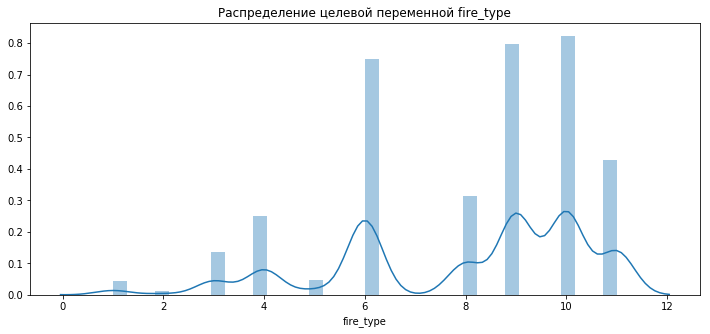

In [20]:
plt.figure(figsize=(12,5))
plt.title("Распределение целевой переменной fire_type")
ax = sns.distplot(df_features["fire_type"])

In [93]:
df_features_new = df_features.copy()
df_features_new = df_features_new.drop(columns='fire_type_name')

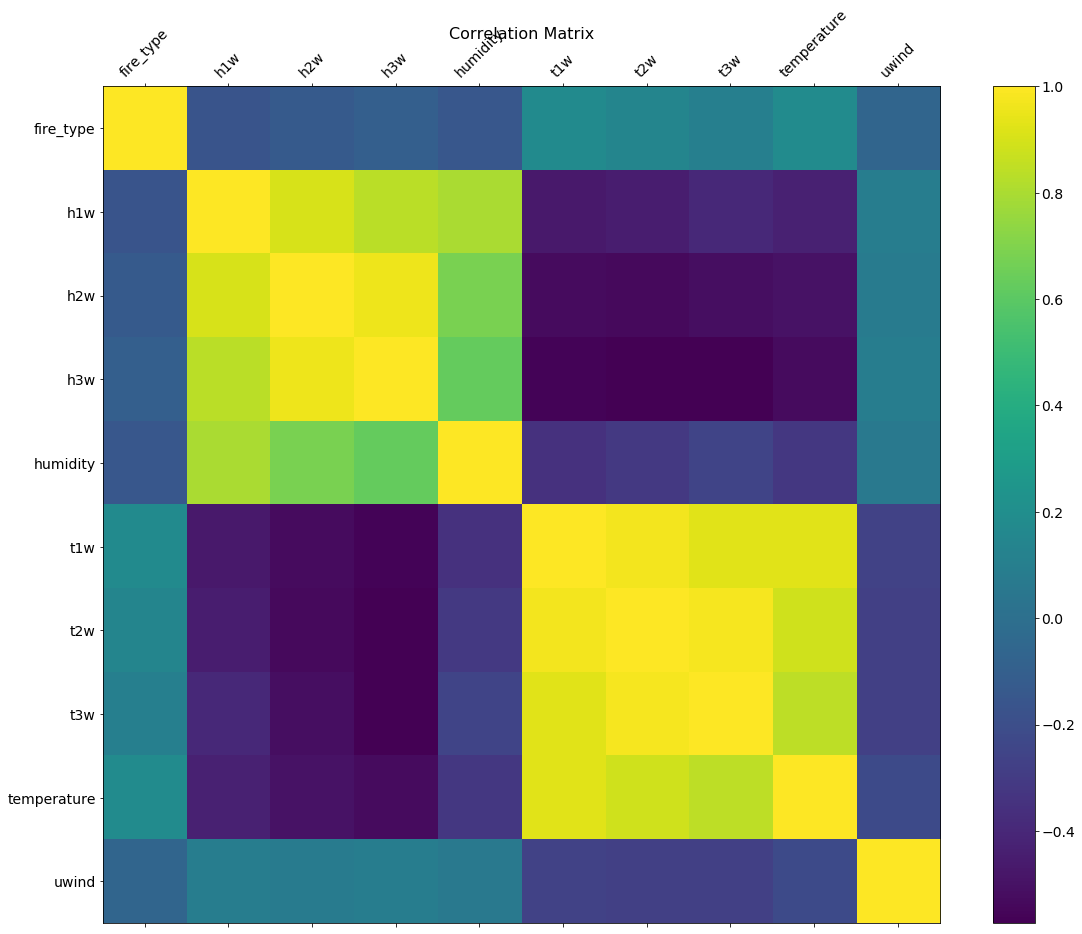

In [94]:
f = plt.figure(figsize=(19, 15))
corr = df_features_new.corr()
plt.matshow(corr, fignum=f.number)
plt.xticks(range(df_features_new.shape[1]), df_features_new.columns, fontsize=14, rotation=45)
plt.yticks(range(df_features_new.shape[1]), df_features_new.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [95]:
corr

,fire_type,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
fire_type,1.000000,-0.162350,-0.127990,-0.099373,-0.147559,0.180915,0.144525,0.106902,0.186752,-0.059322
h1w,-0.162350,1.000000,0.903487,0.835405,0.800387,-0.464036,-0.448013,-0.395083,-0.427055,0.090507
h2w,-0.127990,0.903487,1.000000,0.960677,0.685195,-0.529347,-0.535171,-0.512676,-0.494578,0.081013
h3w,-0.099373,0.835405,0.960677,1.000000,0.628182,-0.559436,-0.573497,-0.573604,-0.525253,0.094466
humidity,-0.147559,0.800387,0.685195,0.628182,1.000000,-0.349867,-0.313407,-0.253606,-0.317260,0.060488
t1w,0.180915,-0.464036,-0.529347,-0.559436,-0.349867,1.000000,0.969329,0.927232,0.929663,-0.264802
t2w,0.144525,-0.448013,-0.535171,-0.573497,-0.313407,0.969329,1.000000,0.978627,0.885960,-0.274093
t3w,0.106902,-0.395083,-0.512676,-0.573604,-0.253606,0.927232,0.978627,1.000000,0.842387,-0.275100
temperature,0.186752,-0.427055,-0.494578,-0.525253,-0.317260,0.929663,0.885960,0.842387,1.000000,-0.220748
uwind,-0.059322,0.090507,0.081013,0.094466,0.060488,-0.264802,-0.274093,-0.275100,-0.220748,1.000000


<p> Из матрицы можно заметить, что существует несколько признаков, которые слабокоррелируют с целевой функцией.</p>

<p> Делим на тестовую и тренировочную выборки и нормализуем данные, так как все данные у нас численные</p>

In [98]:
X = df_features_new.iloc[:, 1:].fillna(0)
y = df_features_new['fire_type']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

15974 6846


In [103]:
# нормализация
train_norm = X_train[X_train.columns]
test_norm = X_test[X_test.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
X_train_norm = std_scale.transform(train_norm)

training_norm_col = pd.DataFrame(X_train_norm, index=train_norm.index, columns=train_norm.columns) 
X_train.update(training_norm_col)
print (X_train.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(X_test_norm, index=test_norm.index, columns=test_norm.columns) 
X_test.update(testing_norm_col)
print (X_test.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
14126 -1.376053 -1.714298 -1.461760 -0.754131  2.007214  2.008775  1.834440   
14442 -1.093350 -1.841258 -2.102201  0.843389  2.494371  2.571975  2.456044   
15391 -0.680211 -0.604445 -0.784061  0.542097  1.025691  1.199949  1.162074   
7473   0.491628  0.844322  0.953849 -0.193104 -0.359849 -0.324471 -0.467146   
12559 -0.167110 -0.343673 -0.521744 -0.819522 -0.166044 -0.145970 -0.005761   

       temperature     uwind  
14126     1.927308 -0.650778  
14442     1.628198 -0.225970  
15391     0.914771 -0.004595  
7473      0.264756 -0.034508  
12559    -0.855586  0.390299  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
12395 -0.301791 -0.012919  0.050156 -0.390502  0.357883  0.315550  0.284840   
18549  1.667082  1.472218  0.980819  1.326189 -0.663217 -0.350845 -0.214699   
4003   0.635304  0.528377  0.596136  0.537207 -0.110365 -0.519804 -0.560575   
3184  -1.642833 -0.383104  0.164440 -1.675729 -0.678981 -0.600001 -0.863163   
283   -0.926729 -1.214189 -0.779109 -0.589734 -1.770864 -1.768226 -1.727530   

       temperature     uwind  
12395     0.463460  0.566803  
18549    -1.058518 -0.124257  
4003      0.617774  0.548854  
3184     -1.193805  1.350601  
283      -1.634543  0.300550  


In [110]:
X_train.describe()

,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
count,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04
mean,6.793114e-17,-9.580139e-17,9.120037e-17,6.397301e-17,-1.272427e-15,-2.458295e-15,2.476713e-15,-1.920031e-15,-5.004135e-18
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-2.584168e+00,-2.836432e+00,-2.736538e+00,-2.381596e+00,-5.061634e+00,-4.818160e+00,-4.480435e+00,-5.094932e+00,-5.111260e+00
25%,-6.791704e-01,-6.816147e-01,-6.602050e-01,-7.241839e-01,-5.497101e-01,-5.834272e-01,-5.868172e-01,-5.329596e-01,-4.892331e-01
50%,1.083176e-02,2.843453e-02,7.023367e-02,-5.193129e-02,-2.019415e-02,-4.592054e-02,-6.603348e-02,1.532259e-02,8.515430e-02
75%,6.980462e-01,7.383159e-01,7.478182e-01,6.948814e-01,6.265498e-01,5.725373e-01,5.774467e-01,6.864702e-01,6.176594e-01
max,2.901247e+00,2.786791e+00,2.692579e+00,2.854038e+00,2.637424e+00,2.617563e+00,2.501689e+00,2.485366e+00,3.444724e+00


In [112]:
X_train.head(5)

,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
14126,-1.376053,-1.714298,-1.461760,-0.754131,2.007214,2.008775,1.834440,1.927308,-0.650778
14442,-1.093350,-1.841258,-2.102201,0.843389,2.494371,2.571975,2.456044,1.628198,-0.225970
15391,-0.680211,-0.604445,-0.784061,0.542097,1.025691,1.199949,1.162074,0.914771,-0.004595
7473,0.491628,0.844322,0.953849,-0.193104,-0.359849,-0.324471,-0.467146,0.264756,-0.034508
12559,-0.167110,-0.343673,-0.521744,-0.819522,-0.166044,-0.145970,-0.005761,-0.855586,0.390299


In [153]:
%%time
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.39858520095154626 20
CPU times: user 1min, sys: 200 ms, total: 1min
Wall time: 51 s


In [154]:
knn_20 = KNeighborsClassifier(n_neighbors = 20, weights='distance').fit(X_train, y_train)
err_train = np.mean(y_train != knn_20.predict(X_train))
err_test  = np.mean(y_test  != knn_20.predict(X_test))
Accuracy = knn_20.score(X_test, y_test)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.16983848754225617 0.39000876424189307
0.6099912357581069 accuracy


### Градиентный бустинг
<p>Результат вышел хуже, чем в knn с оптимально подобранным количеством соседей.</p>

In [138]:
fire_classifier = GradientBoostingClassifier(learning_rate=0.001, n_estimators=300)

In [139]:
fire_classifier.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [140]:
acc_boosting = fire_classifier.score(X_test, y_test)

In [141]:
y_test_predict = fire_classifier.predict(X_test)
err_train = np.mean(y_train != fire_classifier.predict(X_train))
err_test = np.mean(y_test != y_test_predict)

In [142]:
print('accuracy', acc_boosting)
print(err_train, err_test)

accuracy 0.3678060181127666
0.6090522098409916 0.6321939818872334


### Попытка улучшить baseline решение на основе feature selection с деревьями решений

In [145]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
New_features = model.transform(X)
model.get_support()
New_features.shape

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(22820, 4)

In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
Classifiers = [DecisionTreeClassifier(),LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),RandomForestClassifier(n_estimators=200)]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(pd.DataFrame(New_features), y , test_size = 0.3, random_state =  92)

In [150]:
%%time
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_sel, y_train_sel)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.3923250281707775 55
CPU times: user 24.6 s, sys: 164 ms, total: 24.8 s
Wall time: 16.5 s


In [152]:
knn_20 = KNeighborsClassifier(n_neighbors = 20, weights='distance').fit(X_train_sel, y_train_sel)
err_train = np.mean(y_train_sel != knn_20.predict(X_train_sel))
err_test  = np.mean(y_test_sel  != knn_20.predict(X_test_sel))
Accuracy = knn_20.score(X_test_sel, y_test_sel)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.1691498685363716 0.3986269354367514
0.6013730645632486 accuracy


<p> К сожалению не было получено никаких улучшений</p>

In [155]:
# пытаемся сбалансировать классы
df_features.groupby('fire_type').size()

fire_type
1      276
2       76
3      867
4     1588
5      300
6     4744
8     1994
9     5047
10    5212
11    2716
dtype: int64

In [158]:
df_major = df_features_new[df_features_new.fire_type==10]
df_minor_1 = df_features_new[df_features_new.fire_type==1]
df_minor_2 = df_features_new[df_features_new.fire_type==2]
df_minor_3 = df_features_new[df_features_new.fire_type==3]
df_minor_4 = df_features_new[df_features_new.fire_type==4]
df_minor_5 = df_features_new[df_features_new.fire_type==5]
df_minor_6 = df_features_new[df_features_new.fire_type==8]
df_minor_7 = df_features_new[df_features_new.fire_type==11]

In [160]:
df_minor_1 = resample(df_minor_1, replace=True, n_samples=5212, random_state=123)
df_minor_2 = resample(df_minor_2, replace=True, n_samples=5212, random_state=123)
df_minor_3 = resample(df_minor_3, replace=True, n_samples=5212, random_state=123)
df_minor_4 = resample(df_minor_4, replace=True, n_samples=5212, random_state=123)
df_minor_5 = resample(df_minor_5, replace=True, n_samples=5212, random_state=123)
df_minor_6 = resample(df_minor_6, replace=True, n_samples=5212, random_state=123)
df_minor_7 = resample(df_minor_7, replace=True, n_samples=5212, random_state=123)

In [161]:
df_balanced = pd.concat([df_major, df_minor_1, df_minor_2, df_minor_3, df_minor_4, df_minor_5, df_minor_6, df_minor_7])

In [163]:
df_balanced.head(5)

,fire_type,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
41,10,91.828568,61.877918,64.170006,81.709991,258.207184,280.482117,279.543854,258.330017,4.709991
44,10,92.690010,61.877918,64.170006,82.360001,260.480042,280.482117,279.543854,257.950012,6.339996
50,10,96.052849,95.645004,64.170006,93.110001,246.972870,250.001465,279.543854,250.309998,0.229996
54,10,93.772865,93.301437,64.170006,98.259995,254.678604,254.908600,279.543854,243.360001,1.429993
58,10,88.314293,88.650711,64.170006,96.809998,244.970001,251.777161,279.543854,241.580002,-1.720001


In [164]:
X_bal = df_balanced.iloc[:, 1:].fillna(0)
y_bal = df_balanced['fire_type']

In [174]:
df_balanced['fire_type']

41       10
44       10
50       10
54       10
58       10
59       10
62       10
71       10
72       10
101      10
107      10
119      10
142      10
161      10
178      10
181      10
186      10
194      10
220      10
230      10
236      10
239      10
252      10
276      10
279      10
282      10
290      10
291      10
292      10
295      10
         ..
15265    11
5153     11
6334     11
6110     11
16521    11
20803    11
19211    11
16841    11
184      11
19773    11
12443    11
5409     11
3958     11
4585     11
5055     11
16949    11
13128    11
21567    11
16567    11
15874    11
15330    11
19052    11
5723     11
15731    11
11514    11
15029    11
20971    11
5503     11
4242     11
9441     11
Name: fire_type, Length: 41696, dtype: int64

In [165]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size = 0.3, random_state = 42)
N_train_bal, _ = X_train_bal.shape 
N_test_bal,  _ = X_test_bal.shape 
print(N_train_bal, N_test_bal)

29187 12509


In [167]:
# нормализация
train_norm_bal = X_train_bal[X_train_bal.columns]
test_norm_bal = X_test_bal[X_test_bal.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm_bal)
X_train_norm_bal = std_scale.transform(train_norm_bal)

training_norm_col_bal = pd.DataFrame(X_train_norm_bal, index=train_norm_bal.index, columns=train_norm_bal.columns) 
X_train_bal.update(training_norm_col_bal)
print (X_train_bal.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm_bal = std_scale.transform(test_norm_bal)
testing_norm_col_bal = pd.DataFrame(X_test_norm_bal, index=test_norm_bal.index, columns=test_norm_bal.columns) 
X_test_bal.update(testing_norm_col_bal)
print (X_test_bal.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
18392  0.564663  0.814660  0.620139  0.244773  0.128417  0.269970  0.211939   
17114  0.005480 -0.633955 -0.831464  0.216606  1.069762  1.232100  1.361544   
20066  0.042024 -0.045292  0.035410 -0.187826  0.127684  0.037892  0.161785   
22237 -0.914760 -1.556729 -0.931536 -0.323877 -0.629711 -0.760438 -0.565159   
18460  0.075265  0.127186 -0.006972  0.130511  0.618271  0.621385  0.740919   

       temperature     uwind  
18392    -0.335460  1.050398  
17114     0.518163  0.926275  
20066     0.296533 -0.349100  
22237    -0.737992  1.885133  
18460     0.653644  0.094641  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


             h1w        h2w        h3w   humidity         t1w         t2w  \
14852  55.002930  65.268600  62.477615  50.759995  293.465881  290.994324   
893    80.324295  83.080009  86.381424  81.750000  266.215698  264.472931   
18608  63.098530  69.917870  70.438622  60.610001  282.519928  284.178528   
21635  90.230049  82.479973  81.407112  94.029999  263.850037  267.570923   
21941  51.431419  68.133621  72.931435  33.440002  270.938477  274.170624   

              t3w  temperature     uwind  
14852  292.794708   296.109985 -1.960007  
893    261.153870   272.850006  2.050003  
18608  283.717682   284.349976  0.690002  
21635  269.972015   252.630005  3.199997  
21941  274.664185   271.559998  0.309998  


In [168]:
X_train_bal.describe()

,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
count,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04
mean,5.922559e-18,4.830860e-18,1.058681e-16,-1.779811e-17,-1.938430e-17,7.303348e-17,-3.479741e-17,-2.621598e-17,5.737693e-17
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-2.671624e+00,-2.830858e+00,-2.786878e+00,-2.317871e+00,-3.821320e+00,-3.957593e+00,-3.857956e+00,-3.566688e+00,-4.898251e+00
25%,-7.622583e-01,-7.025435e-01,-6.498869e-01,-8.213127e-01,-4.688024e-01,-4.757768e-01,-5.016618e-01,-5.116665e-01,-4.980479e-01
50%,2.482049e-02,7.558576e-02,9.536647e-02,-4.911835e-02,1.153405e-01,8.046295e-02,2.608617e-02,1.383399e-01,6.051164e-02
75%,7.492465e-01,7.142339e-01,7.065084e-01,7.618715e-01,6.876165e-01,6.832580e-01,6.780026e-01,7.249122e-01,6.283754e-01
max,2.157629e+00,2.174755e+00,2.218587e+00,2.118128e+00,2.159419e+00,2.192528e+00,2.151725e+00,1.999859e+00,3.548397e+00


In [169]:
%%time
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_bal, y_train_bal)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.12032754308424987 15
CPU times: user 1min 36s, sys: 436 ms, total: 1min 36s
Wall time: 1min 21s


In [176]:
knn_15 = KNeighborsClassifier(n_neighbors = 15, weights='distance').fit(X_train_bal, y_train_bal)
err_train = np.mean(y_train_bal != knn_15.predict(X_train_bal))
err_test  = np.mean(y_test_bal  != knn_15.predict(X_test_bal))
Accuracy = knn_15.score(X_test_bal, y_test_bal)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.07654092575461678 0.8727316332240787
0.12726836677592135 accuracy


KNN:
Хороший для baseline решения
Сильно зависит от нормализации и балансировки классов
Подвержен curse of dimensionality
Следует проработать значимые признаки, тогда решение вероятно улучшится и ускорится

К сожалению в моем случае не удалось получить после балансировки классов лучший результат. На тренировачном наборе данных результат улучшился, однако на тестовом сильно упал.
Значит ресемплинг классов производился неверно.